---

In [1]:
import gc
from time import perf_counter

from rastervision.core.box import Box
from rastervision.core.data import (
    MinMaxTransformer, RasterioCRSTransformer, 
    StatsTransformer, XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.pipeline.file_system.utils import download_if_needed, json_to_file, file_to_json
from rastervision.core.data.utils import ensure_json_serializable
from rastervision.core import RasterStats
from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset)

import math
from tqdm.auto import tqdm, trange
import numpy as np
from shapely.geometry import mapping
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
import albumentations as A

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---

# Load data

In [2]:
embeddings_json = file_to_json('seasonal_variation_embeddings.json')
embeddings = np.array(embeddings_json['embeddings'])
t_strs = np.array(embeddings_json['t_strs'])
embeddings_flood = np.array(embeddings_json['embeddings_flood'])
t_strs_flood = np.array(embeddings_json['t_strs_flood'])
embeddings_2023 = np.array(embeddings_json['embeddings_2023'])
t_strs_2023 = np.array(embeddings_json['t_strs_2023'])

In [3]:
# def l2_normalize(x):
#     return (x / np.linalg.norm(x, axis=1, keepdims=True))

# embeddings = l2_normalize(embeddings)
# embeddings_flood = l2_normalize(embeddings_flood)
# embeddings_2023 = l2_normalize(embeddings_2023)

In [4]:
# delete extra img for 2018-11-18 with NODATA
t_strs = np.delete(t_strs, [54], axis=0)
embeddings = np.delete(embeddings, [54], axis=0)

In [5]:
embeddings_all = np.concatenate([embeddings, embeddings_2023], axis=0)
t_strs_all = np.concatenate([t_strs, t_strs_2023], axis=0)

In [6]:
from datetime import datetime

t_doy = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs])
t_doy_flood = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs_flood])
t_doy_2023 = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs_2023])
t_doy_all = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs_all])

In [7]:
def to_t_day(t_str):
    return (datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_year + 
     np.clip(datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday / 365, 0, 1))

In [8]:
t_day = np.array([to_t_day(t_str) for t_str in t_strs])
t_day_flood = np.array([to_t_day(t_str) for t_str in t_strs_flood])
t_day_2023 = np.array([to_t_day(t_str) for t_str in t_strs_2023])
t_day_all = np.array([to_t_day(t_str) for t_str in t_strs_all])

In [9]:
mu = embeddings.mean(axis=0)
sigma = embeddings.std(axis=0)

In [10]:
z = np.clip(np.nan_to_num((embeddings - mu) / sigma), -6, 6)
z_flood = np.clip(np.nan_to_num((embeddings_flood - mu) / sigma), -6, 6)
z_2023 = np.clip(np.nan_to_num((embeddings_2023 - mu) / sigma), -6, 6)
z_all = np.clip(np.nan_to_num((embeddings_all - mu) / sigma), -6, 6)

In [11]:
data = np.load('chips_flooding.npz')
# remove extra img for 2018-11-18 (/w NODATA) and extra img for 2021-10-18
chips = np.delete(data['chips'], [54, 162], axis=0)
t_strs_chips = np.delete(data['t_strs'], [54, 162], axis=0)
assert np.all(t_strs_chips == t_strs_all)

---

# Animation

In [204]:
plt.close('all')
try: del fig
except: pass

trail_len = 5
fig, (ax_img, ax_emb) = plt.subplots(
    nrows=1, 
    ncols=2, 
    figsize=(12, 4), 
    squeeze=True,
    tight_layout=True,
    gridspec_kw=dict(
        width_ratios=[1, 2],
    ),
)

def data_gen():
    # with tqdm(zip(t_strs, embeddings / embeddings.max()), total=len(t_strs)) as bar:
    #     for t_str, e in bar:
    #         bar.set_postfix_str(t_str)
    #         yield t_str, e
    T = len(t_strs_all)
    for i in trange(T):
        # if i > 10:
        #     break
        bar.set_postfix_str(t_strs_all[i])
        yield i

artists_to_clear = []

def init():
    return [ax_img, ax_emb]


def run(data):
    i = data
    ax_img.clear()
    ax_img.axis('off')
    ax_img.imshow(chips[i])
    ax_emb.clear()
    inds = [i]
    for j in range(max(0, i - trail_len), i):
        # c = 'red' if t_strs[j] in t_strs_flood_set else 'gray'
        # ax.plot(z[j][e_inds], c=c, alpha=(1.5)**(j-i))
        inds.append(j)
    # c = 'r' if t_strs[i] in t_strs_flood_set else 'k'
    # ax.plot(z[i][e_inds], c=c, alpha=.5)
    ax_emb.plot(z_all[inds].mean(axis=0), c='k', alpha=.5)
    fig.suptitle(datetime.strptime(t_strs_all[i], '%Y-%m-%d').strftime('%Y-%b-%d'))
    ax_img.set_title('Input image')
    ax_emb.set_title('NN embedding')
    ax_emb.set_xlim((0, len(e_inds)))
    ax_emb.set_xlim((0, 512))
    ax_emb.set_ylim((-3, 3))
    ax_emb.set_xlabel('Embedding vector index')
    ax_emb.set_ylabel('z')
    ax_emb.spines['top'].set_visible(False)
    ax_emb.spines['right'].set_visible(False)
    ax_emb.spines['bottom'].set_visible(False)
    ax_emb.spines['left'].set_visible(False)
    return [ax_img, ax_emb]

anim = animation.FuncAnimation(fig, run, data_gen, init_func=init, interval=120)
anim.save('test_z.gif', savefig_kwargs=dict(transparent=False, facecolor='w'))

  0%|          | 0/235 [00:00<?, ?it/s]

In [226]:
plt.close('all')
try: del fig
except: pass

trail_len = 3
_z_all_l2 = (embeddings_all / np.linalg.norm(embeddings_all, axis=1, keepdims=True))
_z_all_l2 = _z_all_l2 - _z_all_l2.mean(axis=0)
fig, (ax_img, ax_emb) = plt.subplots(
    nrows=1, 
    ncols=2, 
    figsize=(12, 4), 
    squeeze=True,
    tight_layout=True,
    gridspec_kw=dict(
        width_ratios=[1, 2],
    ),
)

def data_gen():
    # with tqdm(zip(t_strs, embeddings / embeddings.max()), total=len(t_strs)) as bar:
    #     for t_str, e in bar:
    #         bar.set_postfix_str(t_str)
    #         yield t_str, e
    T = len(t_strs_all)
    for i in trange(T):
        # if i > 10:
        #     break
        bar.set_postfix_str(t_strs_all[i])
        yield i

artists_to_clear = []

def init():
    return [ax_img, ax_emb]


def run(data):
    i = data
    ax_img.clear()
    ax_img.axis('off')
    ax_img.imshow(chips[i])
    ax_emb.clear()
    inds = [i]
    for j in range(max(0, i - trail_len), i):
        # c = 'red' if t_strs[j] in t_strs_flood_set else 'gray'
        # ax.plot(z[j][e_inds], c=c, alpha=(1.5)**(j-i))
        inds.append(j)
    # c = 'r' if t_strs[i] in t_strs_flood_set else 'k'
    # ax.plot(z[i][e_inds], c=c, alpha=.5)
    ax_emb.plot(_z_all_l2[inds].mean(axis=0), c='k', alpha=.5)
    fig.suptitle(datetime.strptime(t_strs_all[i], '%Y-%m-%d').strftime('%Y-%b-%d'))
    ax_img.set_title('Input image')
    ax_emb.set_title('NN embedding')
    ax_emb.set_xlim((0, len(e_inds)))
    ax_emb.set_xlim((0, 512))
    ax_emb.set_ylim((-.1, .1))
    ax_emb.set_yticks([], [])
    ax_emb.set_xlabel('Embedding vector index')
    ax_emb.set_ylabel('z')
    ax_emb.spines['top'].set_visible(False)
    ax_emb.spines['right'].set_visible(False)
    ax_emb.spines['bottom'].set_visible(False)
    # ax_emb.spines['left'].set_visible(False)
    return [ax_img, ax_emb]

anim = animation.FuncAnimation(fig, run, data_gen, init_func=init, interval=120)
anim.save('anim_embeddings_pk_flood.gif', savefig_kwargs=dict(transparent=False, facecolor='w'))

  0%|          | 0/235 [00:00<?, ?it/s]

In [ ]:
plt.close('all')
try: del fig
except: pass

trail_len = 20
def data_gen():
    # with tqdm(zip(t_strs, embeddings / embeddings.max()), total=len(t_strs)) as bar:
    #     for t_str, e in bar:
    #         bar.set_postfix_str(t_str)
    #         yield t_str, e
    for i in trange(len(t_strs)):
        bar.set_postfix_str(t_strs[i])
        yield i

fig, (ax_img, ax_emb) = plt.subplots(nrows=1, ncols=2, figsize=[10, 5], squeeze=True)

artists_to_clear = []

def init():
    # ax_space_1.axis('off')
    # ax_in.imshow(Z_in, origin='lower')
    # ax_in.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False, labeltop=False)
    # ax_space_1.add_artist(ab)
    # return [ax_in, ax_out, ab, im]
    ax.set_xlim((0, 512))
    return [ax]


def run(data):
    i = data
    ax_img.imshow(Z_in, zorder=10, origin='lower')
    ax_emb.clear()
    # for ef in (embeddings_flood / embeddings.max()):
    #     ax.plot(ef, c='r', alpha=0.1)
    for j in range(max(0, i - trail_len), i):
        c = 'red' if t_strs[j] in t_strs_flood_set else 'gray'
        ax.plot(embeddings_n[j], c=c, alpha=(1.2)**(j-i))
    c = 'k' if t_strs[i] in t_strs_flood_set else 'k'
    ax_emb.plot(embeddings_n[i], c=c, alpha=.5)
    ax_emb.set_title(t_strs[i])
    ax_emb.set_xlim((0, 512))
    ax_emb.set_ylim((-0.2, 1.2))
    # artists_to_clear.append(ax)
    
    return [ax]

anim = animation.FuncAnimation(fig, run, data_gen, init_func=init, interval=200)
anim.save('test.gif', savefig_kwargs=dict(transparent=False, facecolor='w'))

---

# Embedding comparison

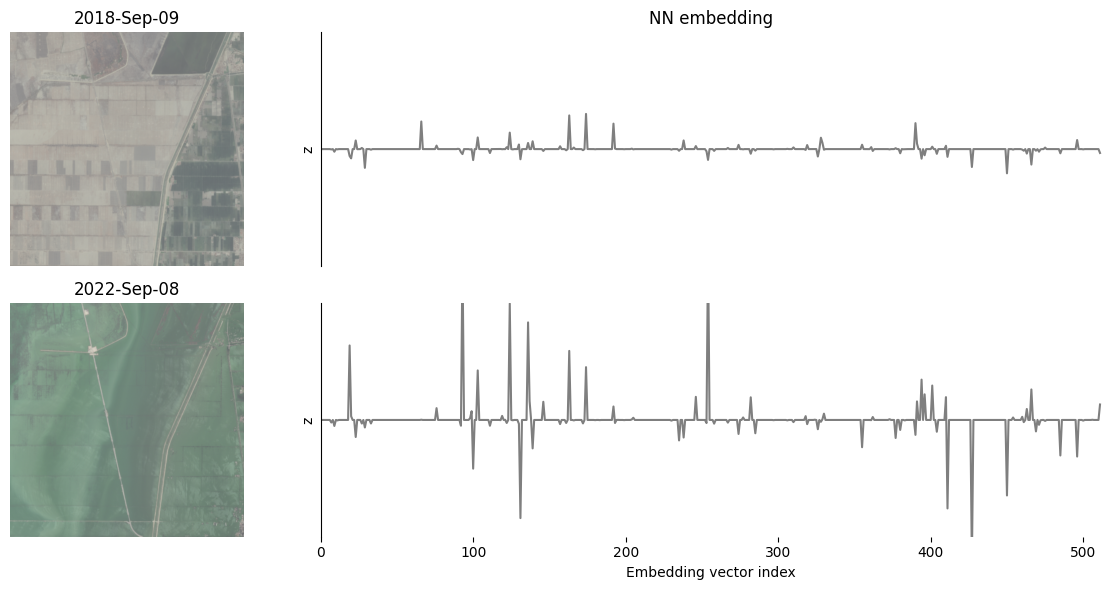

In [13]:
_z_all_l2 = (embeddings_all / np.linalg.norm(embeddings_all, axis=1, keepdims=True))
_z_all_l2 = _z_all_l2 - _z_all_l2.mean(axis=0)
fig, axs = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(12, 6), 
    tight_layout=True,
    gridspec_kw=dict(
        width_ratios=[1, 2],
    ),
)
for i, idx in enumerate([43, 201]):
    ax_img, ax_emb = axs[i]
    ax_img.axis('off')
    ax_img.imshow(chips[idx])
    ax_emb.plot(_z_all_l2[idx], c='k', alpha=.5)
    ax_img.set_title(datetime.strptime(t_strs_all[idx], '%Y-%m-%d').strftime('%Y-%b-%d'))
    ax_emb.set_xlim((0, 512))
    ax_emb.set_ylim((-.1, .1))
    ax_emb.set_yticks([], [])
    ax_emb.set_ylabel('z')
    if i == 0:
        ax_emb.set_xticks([], [])
        ax_emb.set_title('NN embedding')
    if i == 1:
        ax_emb.set_xlabel('Embedding vector index')
    ax_emb.spines['top'].set_visible(False)
    ax_emb.spines['right'].set_visible(False)
    ax_emb.spines['bottom'].set_visible(False)
plt.show()

In [48]:
fig.savefig('emb_compare_pk_flood.png', bbox_inches='tight', pad_inches=0.2)

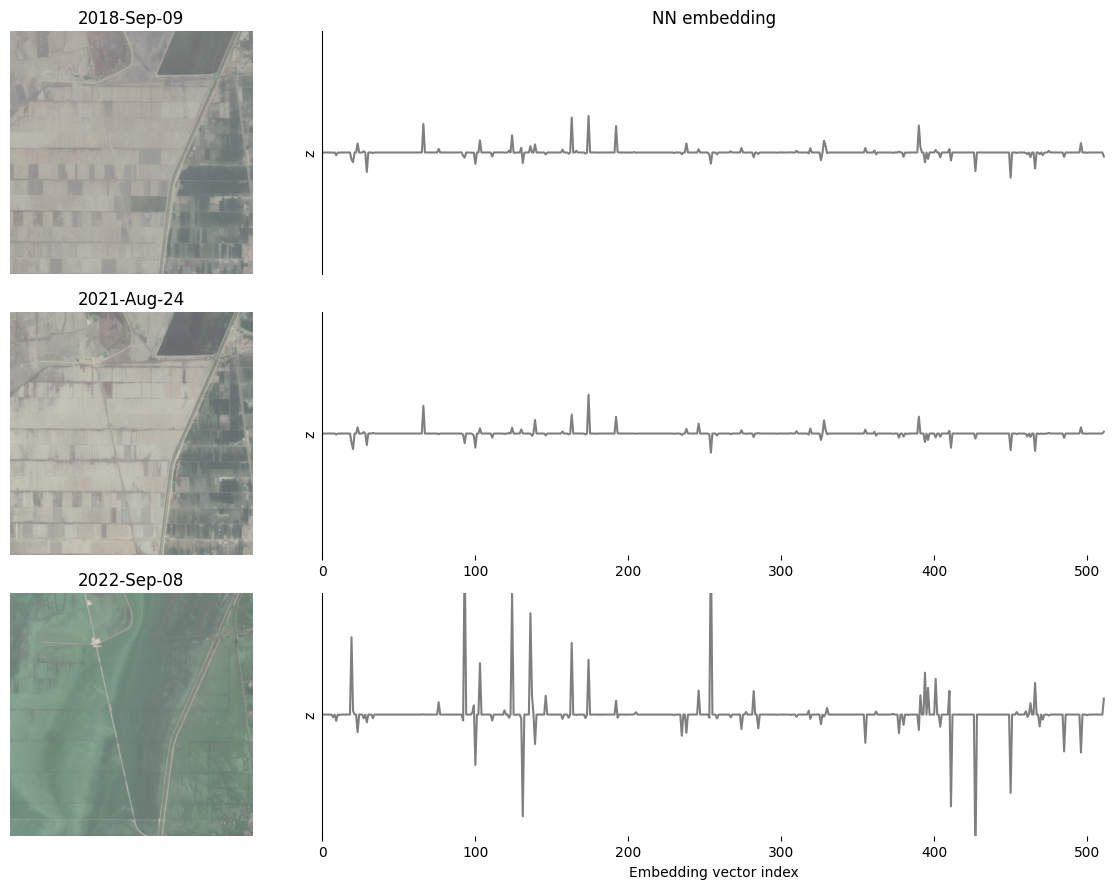

In [14]:
_z_all_l2 = (embeddings_all / np.linalg.norm(embeddings_all, axis=1, keepdims=True))
_z_all_l2 = _z_all_l2 - _z_all_l2.mean(axis=0)
fig, axs = plt.subplots(
    nrows=3, 
    ncols=2, 
    figsize=(12, 3*3), 
    tight_layout=True,
    gridspec_kw=dict(
        width_ratios=[1, 2],
    ),
)

inds = [43, 156, 201]
for i, idx in enumerate(inds):
    ax_img, ax_emb = axs[i]
    ax_img.axis('off')
    ax_img.imshow(chips[idx])
    ax_emb.plot(_z_all_l2[idx], c='k', alpha=.5)
    ax_img.set_title(datetime.strptime(t_strs_all[idx], '%Y-%m-%d').strftime('%Y-%b-%d'))
    ax_emb.set_xlim((0, 512))
    ax_emb.set_ylim((-.1, .1))
    ax_emb.set_yticks([], [])
    ax_emb.set_ylabel('z')
    if i == 0:
        ax_emb.set_xticks([], [])
        ax_emb.set_title('NN embedding')
    if i == len(inds) - 1:
        ax_emb.set_xlabel('Embedding vector index')
    ax_emb.spines['top'].set_visible(False)
    ax_emb.spines['right'].set_visible(False)
    ax_emb.spines['bottom'].set_visible(False)
plt.show()

In [15]:
fig.savefig('emb_compare_3_pk_flood.png', bbox_inches='tight', pad_inches=0.2)

In [ ]:
[43, 156, 201]

In [70]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [41]:
dist_sm = np.linalg.norm(_z_all_l2[43] - _z_all_l2[156])
dist_lg = np.linalg.norm(_z_all_l2[43] - _z_all_l2[201])
dist_sm_rel = 1
dist_lg_rel = dist_lg / dist_sm
dist_lg_rel

9.873206796993394

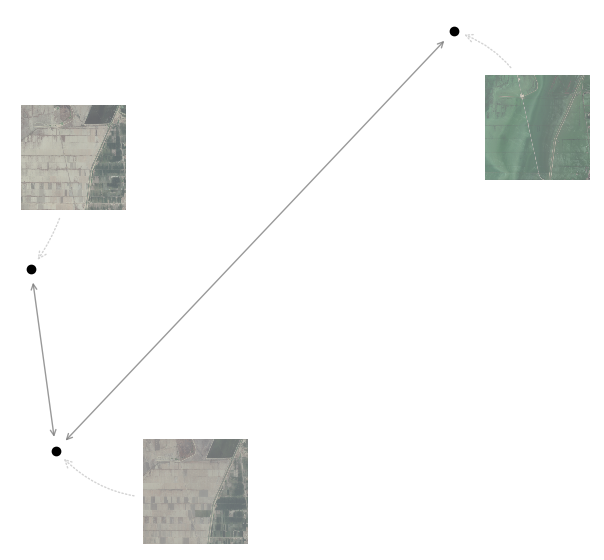

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

x, y = np.array([0, -0.5, 8]), np.array([0, np.sqrt(3)/2, 2])
x += 2
y += 2
ax.scatter(x, y, c='k')
ax.annotate('', xy=(x[0], y[0]), xytext=(x[1], y[1]), arrowprops=dict(arrowstyle='<->', shrinkA=10, shrinkB=10, ec='gray', alpha=0.8))
ax.annotate('', xy=(x[0], y[0]), xytext=(x[2], y[2]), arrowprops=dict(arrowstyle='<->', shrinkA=10, shrinkB=10, ec='gray', alpha=0.8))

img_inds = np.array([43, 156, 201])
img_offsets = [(100, -30), (30, 80), (60, -70)]
arcs = [-0.3, -0.15, 0.3]
for i, (j, offset, arcrad) in enumerate(zip(img_inds, img_offsets, arcs)):
    imagebox = OffsetImage(chips[j], zoom=0.15)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, (x[i], y[i]),
                        xybox=offset,
                        xycoords='data',
                        boxcoords='offset points',
                        frameon=False,
                        arrowprops=dict(
                            arrowstyle="->",
                            shrinkB=8,
                            connectionstyle=f'arc3,rad={arcrad}',
                            ec='lightgray',
                            ls=':',
                        )
        )
    ax.add_artist(ab)

ax.axis('off')
# ax.set_xticks([], [])
# ax.set_yticks([], [])
# ax.set_xlim((0, 15))
# ax.set_ylim((0, 6))
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
plt.show()

---

# t-SNE

In [260]:
from sklearn.manifold import TSNE

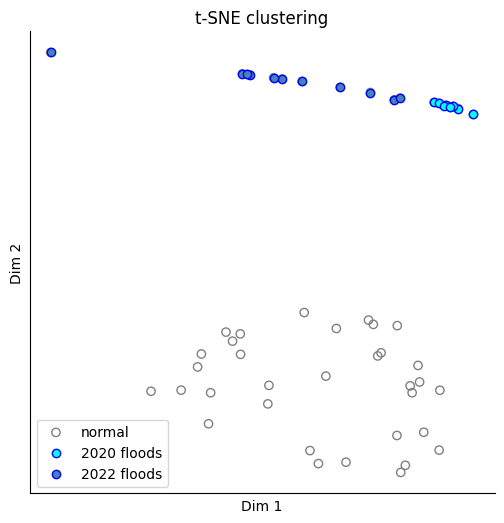

In [261]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

m_inds = np.where([int(s.split('-')[1]) in [8, 9, 10] for s in t_strs_all])[0]
t_strs_m = t_strs_all[m_inds]
t_strs_flood_set = set(t_strs_flood)
t_strs_m_flood_2020_mask = np.array([t_str in t_strs_flood_set and t_str.startswith('2020') and t_str >= '2020-09-08' for t_str in t_strs_m])
t_strs_m_flood_2022_mask = np.array([t_str in t_strs_flood_set and t_str.startswith('2022') for t_str in t_strs_m])

tsne = TSNE()
_ = tsne.fit(embeddings_all[m_inds])
tsne_emb = tsne.embedding_

ax.scatter(tsne_emb[:, 0], tsne_emb[:, 1], ec='gray', fc='none', label='normal')
ax.scatter(tsne_emb[t_strs_m_flood_2020_mask, 0], tsne_emb[t_strs_m_flood_2020_mask, 1], ec='b', fc='cyan', label='2020 floods')
ax.scatter(tsne_emb[t_strs_m_flood_2022_mask, 0], tsne_emb[t_strs_m_flood_2022_mask, 1], ec='b', fc='steelblue', label='2022 floods')
# ax.scatter(tsne_emb[t_strs_m_flood_2022_mask, 0], tsne_emb[t_strs_m_flood_2022_mask, 1], ec='r', fc='pink', label='2022 floods')

ax.legend()
ax.set_title('t-SNE clustering')
ax.set_xticks([], [])
ax.set_yticks([], [])
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

plt.show()

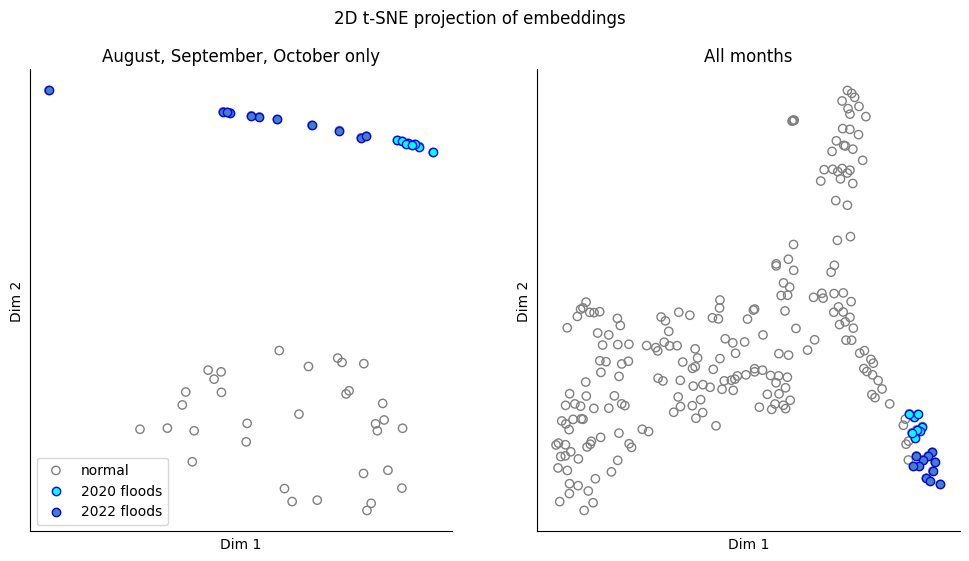

In [262]:
plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(12, 6), squeeze=True)
fig.suptitle('2D t-SNE projection of embeddings')

for i, (ax, ms) in enumerate(zip(axs, [[8, 9, 10], range(1, 13)])):
    m_inds = np.where([int(s.split('-')[1]) in ms for s in t_strs_all])[0]
    t_strs_m = t_strs_all[m_inds]
    t_strs_flood_set = set(t_strs_flood)
    t_strs_m_flood_2020_mask = np.array([t_str in t_strs_flood_set and t_str.startswith('2020') and t_str >= '2020-09-08' for t_str in t_strs_m])
    t_strs_m_flood_2022_mask = np.array([t_str in t_strs_flood_set and t_str.startswith('2022') for t_str in t_strs_m])
    
    tsne = TSNE()
    _ = tsne.fit(embeddings_all[m_inds])
    tsne_emb = tsne.embedding_
    
    ax.scatter(tsne_emb[:, 0], tsne_emb[:, 1], ec='gray', fc='none', label='normal')
    ax.scatter(tsne_emb[t_strs_m_flood_2020_mask, 0], tsne_emb[t_strs_m_flood_2020_mask, 1], ec='b', fc='cyan', label='2020 floods')
    ax.scatter(tsne_emb[t_strs_m_flood_2022_mask, 0], tsne_emb[t_strs_m_flood_2022_mask, 1], ec='b', fc='steelblue', label='2022 floods')
    # ax.scatter(tsne_emb[t_strs_m_flood_2022_mask, 0], tsne_emb[t_strs_m_flood_2022_mask, 1], ec='r', fc='pink', label='2022 floods')

    if i == 0:
        ax.legend()
        ax.set_title('August, September, October only')
    elif i == 1:
        ax.set_title('All months')
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

plt.show()

In [263]:
fig.savefig('emb_tsne_pk_flood.png', bbox_inches='tight', pad_inches=0.2)

---

# PCA

In [16]:
from sklearn.decomposition import PCA, IncrementalPCA, FastICA, FactorAnalysis
from sklearn.linear_model import (
    LinearRegression, Ridge, BayesianRidge, HuberRegressor, RANSACRegressor,
    TheilSenRegressor, )

def t_to_feats(t):
    feat_1 = np.sin(t * np.pi * 2)
    feat_2 = np.cos(t * np.pi * 2)
    return np.stack([feat_1, feat_2], axis=1)

In [17]:
pca = PCA(whiten=True)
_ = pca.fit(embeddings)

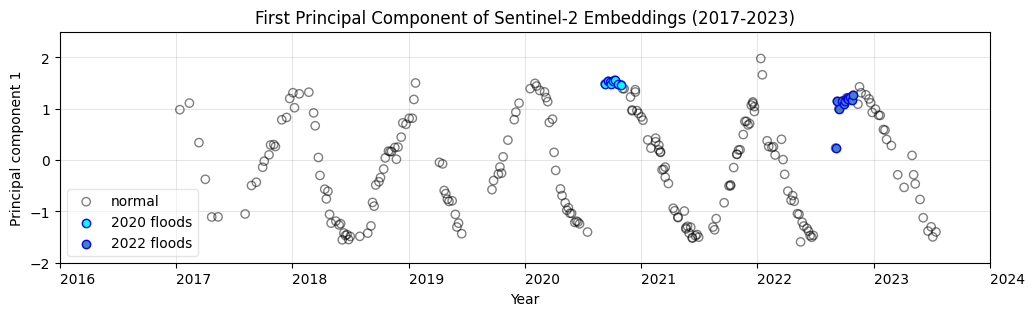

In [256]:
pc = 0

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(12, 3), squeeze=True)

pca_emb = pca.transform(embeddings_all)
x = t_day_all
ax.scatter(x, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal')
# ax.plot(x, pca_emb[:, pc], c='k', alpha=0.25)

flood_inds_2020 = np.where([t_str.startswith('2020') and t_str >= '2020-09-08' for t_str in t_strs_flood])[0]
pca_emb = pca.transform(embeddings_flood[flood_inds_2020])
x = t_day_flood[flood_inds_2020]
ax.scatter(x, pca_emb[:, pc], ec='b', fc='cyan', label='2020 floods')

flood_inds_2022 = np.where([t_str.startswith('2022') for t_str in t_strs_flood])[0]
pca_emb = pca.transform(embeddings_flood[flood_inds_2022])
x = t_day_flood[flood_inds_2022]
ax.scatter(x, pca_emb[:, pc], ec='b', fc='steelblue', label='2022 floods')
# ax.scatter(x, pca_emb[:, pc], ec='r', fc='pink', label='2022 floods')


ax.legend(loc='lower left', framealpha=0.5)
ax.grid('--', c='k', alpha=0.1)
# ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
# ax.set_xlabel('Month')
ax.set_xlim((2016, 2024))
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment('left')
ax.set_ylim((-2, 2.5))
ax.set_ylabel(f'Principal component {pc + 1}')
ax.set_xlabel('Year')

plt.show()

In [257]:
fig.savefig('emb_sine_pk_flood.png', bbox_inches='tight', pad_inches=0.2)

---

In [55]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [56]:
pca = PCA(whiten=True)
pca.fit(embeddings)
# pc = 0

lr = RANSACRegressor()
Y = pca.transform(embeddings_all)[:, pc]
t = np.clip(t_doy_all / 365, 0, 1)
X = t_to_feats(t)
_ = lr.fit(X, Y)

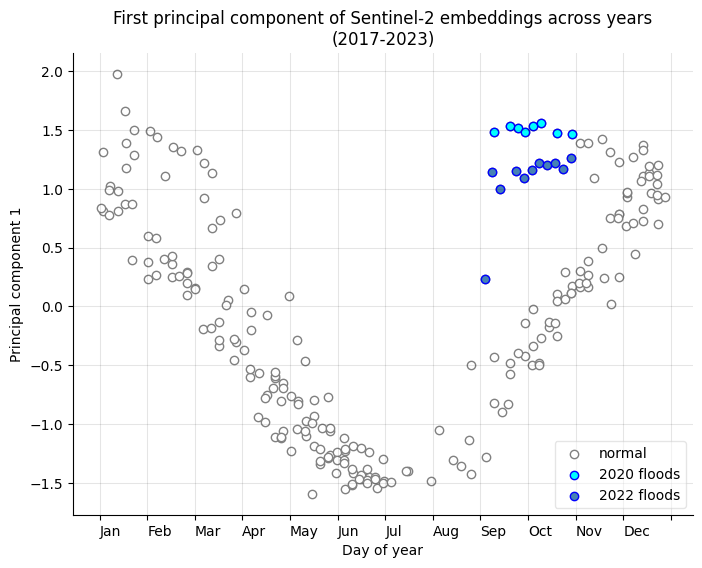

In [258]:
plt.close('all')
cmap = plt.get_cmap('Reds')
fig, ax = plt.subplots(1, 1, figsize=(8, 6), squeeze=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pc = 0
pca_emb = pca.transform(embeddings_all)
x = np.clip(t_doy_all / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], fc='w', ec='gray', alpha=1, label='normal')

flood_inds_2020 = np.where([t_str.startswith('2020') and t_str >= '2020-09-08' for t_str in t_strs_flood])[0]
pca_emb = pca.transform(embeddings_flood[flood_inds_2020])
x = np.clip(t_doy_flood[flood_inds_2020] / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='b', fc='cyan', label='2020 floods')

flood_inds_2022 = np.where([t_str.startswith('2022') for t_str in t_strs_flood])[0]
pca_emb = pca.transform(embeddings_flood[flood_inds_2022])
x = np.clip(t_doy_flood[flood_inds_2022] / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='b', fc='steelblue', label='2022 floods')

ax.legend(loc='lower right', framealpha=0.5)
ax.grid('--', c='k', alpha=0.1)
ax.set_xticks(np.arange(0, 13) / 12, 
              ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment('left')
ax.set_title('First principal component of Sentinel-2 embeddings across years\n(2017-2023)')
ax.set_xlabel('Day of year')
ax.set_ylabel('Principal component 1')
plt.show()

In [259]:
fig.savefig('pca_pk_flood.png', bbox_inches='tight', pad_inches=0.2)

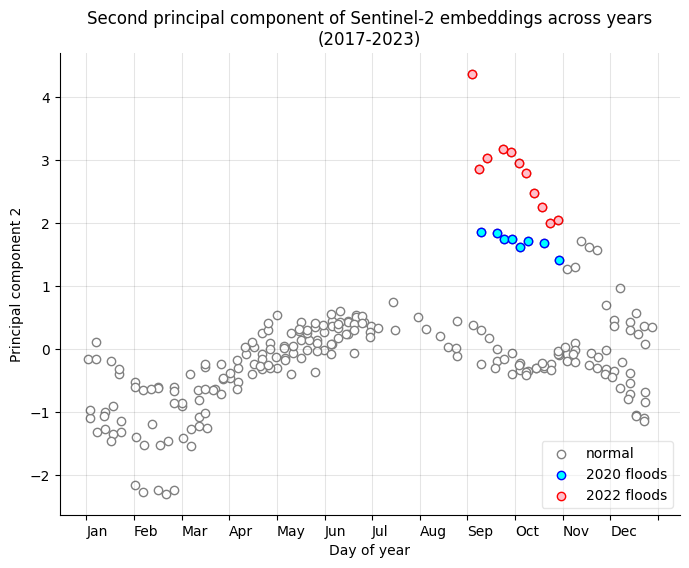

In [90]:
plt.close('all')
cmap = plt.get_cmap('Reds')
fig, ax = plt.subplots(1, 1, figsize=(8, 6), squeeze=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pc = 1
pca_emb = pca.transform(embeddings_all)
x = np.clip(t_doy_all / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], fc='w', ec='gray', alpha=1, label='normal')

flood_inds_2020 = np.where([t_str.startswith('2020') and t_str >= '2020-09-08' for t_str in t_strs_flood])[0]
pca_emb = pca.transform(embeddings_flood[flood_inds_2020])
x = np.clip(t_doy_flood[flood_inds_2020] / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='b', fc='cyan', label='2020 floods')

flood_inds_2022 = np.where([t_str.startswith('2022') for t_str in t_strs_flood])[0]
pca_emb = pca.transform(embeddings_flood[flood_inds_2022])
x = np.clip(t_doy_flood[flood_inds_2022] / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='r', fc='pink', label='2022 floods')

ax.legend(loc='lower right', framealpha=0.5)
ax.grid('--', c='k', alpha=0.1)
ax.set_xticks(np.arange(0, 13) / 12, 
              ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment('left')
ax.set_title('Second principal component of Sentinel-2 embeddings across years\n(2017-2023)')
ax.set_xlabel('Day of year')
ax.set_ylabel('Principal component 2')
plt.show()

# Regression

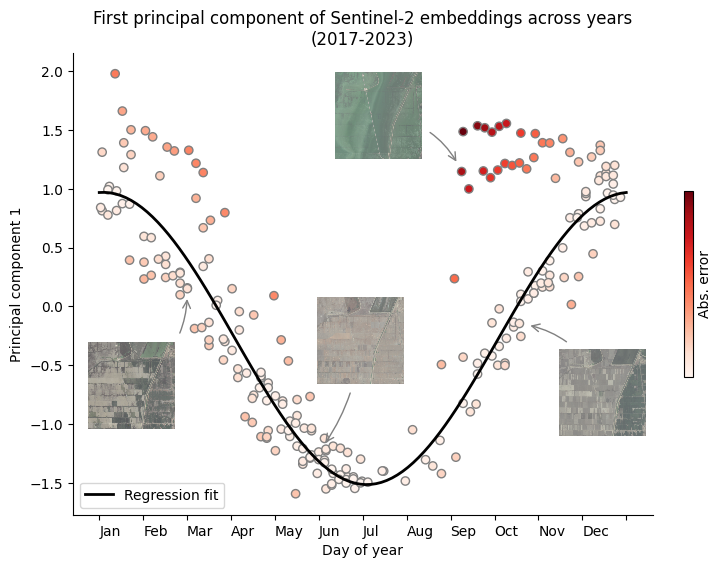

In [91]:
plt.close('all')
cmap = plt.get_cmap('Reds')
fig, ax = plt.subplots(1, 1, figsize=(8, 6), squeeze=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pc = 0
pca_emb = pca.transform(embeddings_all)
x = np.clip(t_doy_all / 365, 0, 1)
# error = np.sqrt((lr.predict(t_to_feats(x)) - pca_emb[:, pc])**2)
error = np.abs(lr.predict(t_to_feats(x)) - pca_emb[:, pc])
norm = Normalize(error.min(), error.max())
cols = cmap(norm(error))
ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)

# ax_ins = inset_axes(
#     ax, 1, 1, bbox_to_anchor=(0.6, 0.9), bbox_transform=ax.transAxes)
# ax_ins.imshow(chips[200])
# ax_ins.axis('off')

img_inds = np.array([132, 33, 161, 201])
img_offsets = [(-40, -70), (30, 80), (60, -50), (-60, 40)]
arcs = [0.3, -0.15, 0.3, -0.3]
for j, offset, arcrad in zip(img_inds, img_offsets, arcs):
    imagebox = OffsetImage(chips[j], zoom=0.125)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, (x[j], pca_emb[j, pc]),
                        xybox=offset,
                        xycoords='data',
                        boxcoords='offset points',
                        frameon=False,
                        arrowprops=dict(
                            arrowstyle="->",
                            shrinkB=8,
                            connectionstyle=f'arc3,rad={arcrad}',
                            ec='gray',
                        )
        )
    ax.add_artist(ab)
# ax.scatter(x[img_inds], pca_emb[img_inds, pc], fc='none', ec='k', s=80, lw=1.5, alpha=0.75)


t = np.linspace(0, 1, 100)
x = t_to_feats(t)
y_pred = lr.predict(x)
ax.plot(t, y_pred, lw=2, c='k', label='Regression fit')
ax.legend(loc='lower left')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, fraction=0.015, ticks=[], label='Abs. error')

# ax.grid('--', axis='both', c='k', alpha=0.1)
ax.set_xticks(np.arange(0, 13) / 12, 
              ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment('left')
ax.set_title('First principal component of Sentinel-2 embeddings across years\n(2017-2023)')
ax.set_xlabel('Day of year')
ax.set_ylabel('Principal component 1')
plt.show()

In [92]:
fig.savefig('pca_reg_pk_flood_err.png', bbox_inches='tight', pad_inches=0.2)

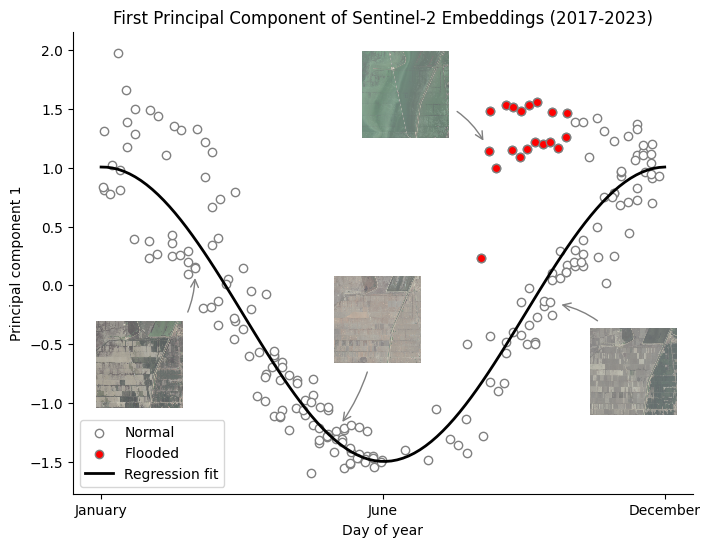

In [139]:
plt.close('all')
cmap = plt.get_cmap('Reds')
fig, ax = plt.subplots(1, 1, figsize=(8, 6), squeeze=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pc = 0
pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], c='w', ec='gray', alpha=1, label='Normal')

pca_emb = pca.transform(embeddings_flood[1:])
x = np.clip(t_doy_flood[1:] / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], c='r', ec='gray', alpha=1, label='Flooded')

x = np.clip(t_doy / 365, 0, 1)
pca_emb = pca.transform(embeddings)

img_inds = [132, 33, 161, 201]
img_offsets = [(-40, -70), (30, 80), (60, -50), (-60, 40)]
arcs = [0.3, -0.15, 0.3, -0.3]
for j, offset, arcrad in zip(img_inds, img_offsets, arcs):
    imagebox = OffsetImage(chips[j], zoom=0.125)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, (x[j], pca_emb[j, pc]),
                        xybox=offset,
                        xycoords='data',
                        boxcoords='offset points',
                        frameon=False,
                        arrowprops=dict(
                            arrowstyle="->",
                            shrinkB=8,
                            connectionstyle=f'arc3,rad={arcrad}',
                            ec='gray',
                        )
        )
    ax.add_artist(ab)

t = np.linspace(0, 1, 100)
x = t_to_feats(t)
y_pred = lr.predict(x)
ax.plot(t, y_pred, lw=2, c='k', label='Regression fit')

ax.legend(loc='lower left')
ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Day of year')
ax.set_ylabel('Principal component 1')
plt.show()

In [28]:
fig.savefig('pca_reg_pk_flood.png', bbox_inches='tight', pad_inches=0.2)

---

# Why the spread in the earlier part of the years?

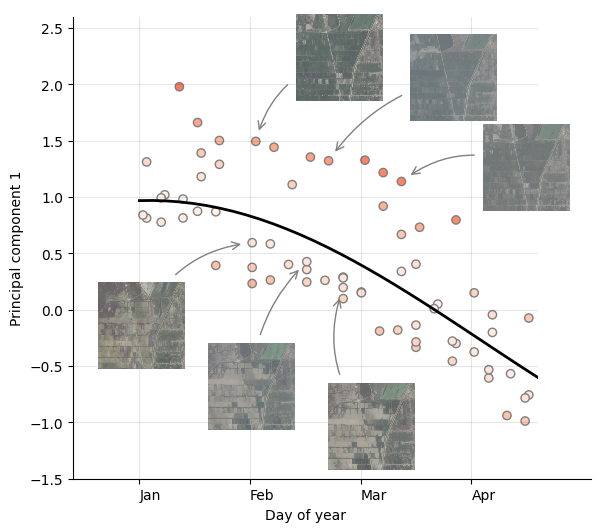

In [253]:
plt.close('all')
cmap = plt.get_cmap('Reds')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pc = 0
pca_emb = pca.transform(embeddings_all)
x = np.clip(t_doy_all / 365, 0, 1)
error = np.abs(lr.predict(t_to_feats(x)) - pca_emb[:, pc])
norm = Normalize(error.min(), error.max())
cols = cmap(norm(error))
ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)


t = np.linspace(0, 1, 100)
x = t_to_feats(t)
y_pred = lr.predict(x)
ax.plot(t, y_pred, lw=2, c='k', label='Regression fit')

# pre_2020_inds = np.where([t_str < '2020' for t_str in t_strs_all])[0]
# pca_emb = pca.transform(embeddings_all[pre_2020_inds])
# x = np.clip(t_doy_all[pre_2020_inds] / 365, 0, 1)
# ax.scatter(x, pca_emb[:, pc], ec='r', fc='pink', label='< 2020')


# pre_2020_inds = np.where([t_str >= '2020' for t_str in t_strs_all])[0]
# pca_emb = pca.transform(embeddings_all[pre_2020_inds])
# x = np.clip(t_doy_all[pre_2020_inds] / 365, 0, 1)
# ax.scatter(x, pca_emb[:, pc], ec='darkgreen', fc='g', label='>= 2020')

pca_emb = pca.transform(embeddings_all)
x = np.clip(t_doy_all / 365, 0, 1)
img_inds = np.array([21, 85, 90, 129, 130, 221])
img_offsets = [(90, 60), (60, 60), (90, 10)] + [(-40, -90), (20, -100), (-80, -60)]
arcs = [0.2, 0.3, 0.3] + [-0.2, -0.3, -0.3]
for j, offset, arcrad in zip(img_inds, img_offsets, arcs):
    imagebox = OffsetImage(chips[j], zoom=0.125)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, (x[j], pca_emb[j, pc]),
                        xybox=offset,
                        xycoords='data',
                        boxcoords='offset points',
                        frameon=False,
                        arrowprops=dict(
                            arrowstyle="->",
                            shrinkB=8,
                            connectionstyle=f'arc3,rad={arcrad}',
                            ec='gray',
                            ls='-'
                        )
        )
    ax.add_artist(ab)

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# plt.colorbar(sm, fraction=0.015, ticks=[], label='Abs. error')

# ax.legend(loc='lower right', framealpha=0.5)
ax.grid('--', c='k', alpha=0.1)
ax.set_xticks(np.arange(0, 13) / 12, 
              ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment('left')
ax.set_xlim((-0.05, 0.3))
ax.set_ylim((-1.5, 2.6))
# ax.set_title('First principal component of Sentinel-2 embeddings across years\n(2017-2023)')
ax.set_xlabel('Day of year')
ax.set_ylabel('Principal component 1')
ax.spines['bottom'].set_bounds(-0.05, 0.34)
# ax.spines['left'].set_visible(False)
# ax.spines['right'].set_visible(False)
plt.show()

In [254]:
fig.savefig('pca_reg_zoom_pk_flood.png', bbox_inches='tight', pad_inches=0.2)

In [176]:
np.where(t_strs_all == '2020-03-07')[0]

array([90])

In [163]:
list(filter(lambda s: 2 <= int(s[5:7]) < 4, t_strs_all[(pca_emb[:, 0] > 1)]))

['2017-02-11',
 '2018-02-21',
 '2020-02-01',
 '2020-02-06',
 '2020-02-16',
 '2020-03-02',
 '2020-03-07',
 '2020-03-12']

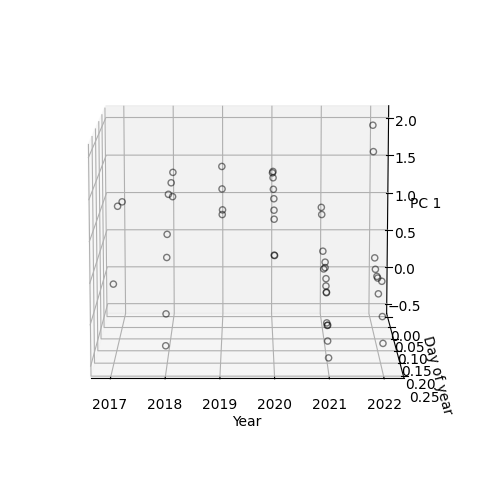

In [51]:
plt.close('all')
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(projection='3d')

pca_emb = pca.transform(embeddings)
x2 = np.clip(t_doy / 365, 0, 1)
x1 = t_day
x1 = x1.astype(int)
mask = x2 <= 0.25
ax.scatter(x1[mask], x2[mask], zs=pca_emb[mask, pc], ec='k', fc='none', alpha=0.5)
# ax.plot(x, pca_emb[:, pc], zs=pca_emb[:, pc+1], c='k', alpha=0.25)

# ax.legend(loc='upper left', framealpha=0.1)
# ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
# ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
# ax.set_xlim((0, 0.5))
ax.set_xlabel('Year')
ax.set_ylabel('Day of year')
ax.set_zlabel('PC 1')
ax.invert_xaxis()
ax.view_init(elev=10, azim=90, roll=0, vertical_axis='z')

plt.show()